In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from embedding_utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

from IPython.display import Image
%load_ext autoreload
%autoreload 2

# gpu check wiki
# spreadsheet for lor

In [2]:
DATADIR = './data/gdb13/'
OUTDIR = './run-6/'
LOGFILE = os.path.join(OUTDIR, 'log.csv')

GRU_HIDDEN_DIM = 512
LATENT_DIM = 256

### Data & Model Parameters

In [3]:
smiles_train, smiles_test = fetch_smiles_gdb13(DATADIR)

In [4]:
params = make_params(
    smiles=smiles_train + smiles_test, 
    GRU_HIDDEN_DIM=GRU_HIDDEN_DIM, 
    LATENT_DIM=LATENT_DIM
)

### Model

In [5]:
encoder = Encoder(params)
encoder.load_state_dict(torch.load(OUTDIR + 'encoder_weights.pth'))

decoder = Decoder(params)
decoder.load_state_dict(torch.load(OUTDIR + 'decoder_weights.pth'))

<All keys matched successfully>

O=C1NC2CC11[NH2+]C2C2COC1C2		OC1C[NH2+]C2CN3CCC2(CC3)C1
O=C1CC2CCC3[NH2+]C2CCCCCCC2		OC1C[NH2+]C2CC3CCC2CCC3)C1
Euclidean Distance of Means: 2.29880952835083
Euclidean Distance of Samples: 22.212167739868164


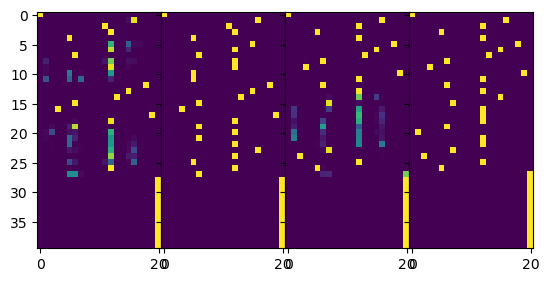

In [6]:
s1, s2 = random.sample(smiles_test, 2)
print(f'{s1}\t\t{s2}')

s1 = to_one_hot(s1, params)
s2 = to_one_hot(s2, params)

mu1, logvar1, z1 = encoder(s1)
mu2, logvar2, z2 = encoder(s2)

s1_pred = decoder(z1)
s2_pred = decoder(z2)

print(f'{from_one_hot(s1_pred, params)[0]}\t\t{from_one_hot(s2_pred, params)[0]}')

print(f"Euclidean Distance of Means: {float(torch.pow(torch.sum(torch.pow(mu1 - mu2, 2)), 0.5))}")
print(f"Euclidean Distance of Samples: {float(torch.pow(torch.sum(torch.pow(z1 - z2, 2)), 0.5))}")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True)

ax1.imshow(torch.softmax(s1_pred, dim=2).squeeze(0).detach().numpy())
ax2.imshow(torch.softmax(s1, dim=2).squeeze(0).detach().numpy())

ax3.imshow(torch.softmax(s2_pred, dim=2).squeeze(0).detach().numpy())
ax4.imshow(torch.softmax(s2, dim=2).squeeze(0).detach().numpy())

plt.subplots_adjust(wspace=0, hspace=0)

## Test

In [7]:
evaluate_ae(encoder, decoder, smiles_test, 10, params=params)

,target,predicted
0,OC1C2CCC(C2)C2=CNC(O)=C12,OC1CCCCC(C1)C1=CCC(OC=C21
1,C1NC23C[NH2+]C4CC(C2)COC1C34,C1CC23C[NH2+]C4CCCCCC2)C1C34
2,C1OC2COC1C1CCCC2OC1,C1OC2CCC1CCCCCC2CC1
3,OC1CCCN2C1=CC1=C2N=CN1,OC1CCCC2C1=CC1=C2C=CS1
4,OC1CC2C3CC4CC3CCC1[NH+]24,OC1CC2C3CCCCCC3CC1[NH+]24
5,C1OC2OCC11CC3C[NH2+]CC21N3,C1OC2CC11CCCCC[NH2+]CCC1O2
6,[NH2+]=C1NCC2CC11CC2COCC1,[NH2+]=C1NCC2CC11CCCC2CC1
7,O=C1CCC2OC3CCC12[NH2+]CC3,O=C1CCC2CC3CCC1)[NH2+]CC3
8,S=C1NCCC2=CC(CN1)=NO2,O=C1CCCC2=C(CCC1)=CO2
9,C1CC2=CN=NN2CC2=CC=NN12,C1CC2=CC=CC2CC2=CC=CN12


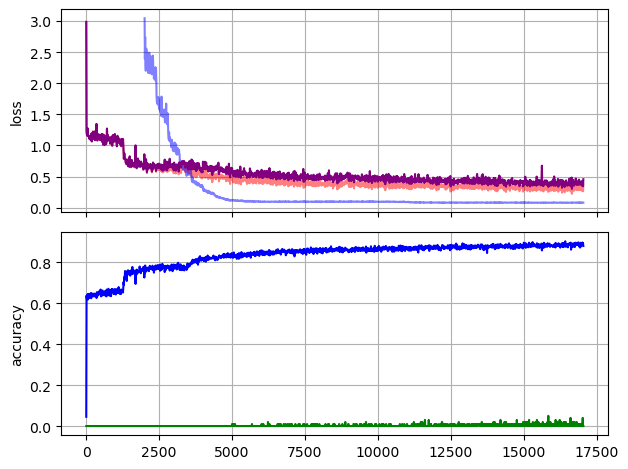

In [8]:
log = pd.read_csv(LOGFILE)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

every = 10

linspace = np.linspace(start=6000, stop=15000)
ax1.set_ylabel('loss')
ax1.plot(log['ce'][::every], color='red', alpha=0.5)
ax1.plot(log['kl'][2000::every], color='blue', alpha=0.5)
ax1.plot(log['loss'][::every], color='purple')
ax1.grid()

ax2.set_ylabel('accuracy')
ax2.plot(log['accuracy'][::every], color='blue')
ax2.plot(log['prec'][::every], color='green')
ax2.grid()

#plt.savefig('run.png')

plt.tight_layout()